## This tutorial introduces how to use the code to: 
1. produce noise map (clip emission regions)
2. measure noise ACF from noise map
3. (from the measured noise ACF) compute noise in the spatially integrated flux or spectrum with given aperture mask.
4. (from the measured noise ACF) simulate noise maps. 

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import astropy.units as u
from spectral_cube import SpectralCube
import numpy as np
from astropy.io import fits
import time
import functools
from scipy import signal
from astropy.stats import sigma_clip
from scipy import ndimage
import scipy
from astropy.modeling import models, fitting

In [2]:
# import all functions in essence.py
from essence.essence import*

## 0. load your data as a spectral cube class

Please download the example data below (ADS/JAO.ALMA2017.1.00394.S PI=Gonzalez Lopez, Jorg)  
https://drive.google.com/file/d/1h0wEPHVebVSjl803r9LnQyBTxfoU2kBY/view?usp=sharing  
,then unzip and place to the same directry of this file.

In [5]:
# Here read band_7 continuum first to use its peak position as the image center 
path='./exampledata/'
band7_cont = SpectralCube.read(path+'cont_robust0.0.image.pbcor.fits')
cy=np.where(band7_cont._data[0, :, :]==np.nanmax(band7_cont._data[0, :, :]))[0][0]
cx=np.where(band7_cont._data[0, :, :]==np.nanmax(band7_cont._data[0, :, :]))[1][0]
#And half width of the figure in [pixels].
n=25
lat_range = [cy-n,cy+n+1]
lon_range = [cx-n,cx+n+1]
# Create a sub_cube cut to these coordinates
band7_cont_s = band7_cont.subcube(xlo=lon_range[0], xhi=lon_range[1], ylo=lat_range[0], yhi=lat_range[1]
                       )#.with_spectral_unit(u.km/u.s,rest_value=oh1_freq,velocity_convention='optical')
_, b1, _ = band7_cont_s.world[0, :, 0]
_, _, l1 = band7_cont_s.world[0, 0, :]

band7 = SpectralCube.read(path+'cont_robust0.0.image.pbcor.fits') #band 7 image 
band7_s=band7.subcube(xlo=l1[0], xhi=l1[-1], ylo=b1[0], yhi=b1[-1]) #band 7 sub image 
band7_ori = SpectralCube.read(path+'cont_robust0.0.image.fits')[0] #band 7 primaly beam uncorrected
band7_pb = SpectralCube.read(path+'cont_robust0.0.pb.fits') # band 7 primaly beam 
band7_psf = SpectralCube.read(path+'cont_robust0.0.psf.fits') # band 7 psf

cii_rest=1900.53690000*u.GHz
redshift_f=4.4074#4.4069770
cii_freq=cii_rest/(redshift_f+1.)

### make all channels have common beam### 
cii_diff = SpectralCube.read(path+'CII_robust05.clean.image.pbcor.fits')
common_beam = cii_diff.beams.common_beam(auto_increase_epsilon=True, tolerance=1e-5)
cii = cii_diff.convolve_to(common_beam)

cii_diff_ori = SpectralCube.read(path+'CII_robust05.clean.image.fits')
common_beam_ori = cii_diff_ori.beams.common_beam(auto_increase_epsilon=True, tolerance=1e-5)
cii_ori = cii_diff_ori.convolve_to(common_beam_ori)

### the data already have common beam across the channel use instead ####
#cii = SpectralCube.read(path+'CII_TT_robust05.clean.image.pbcor.fits')
#cii_ori = SpectralCube.read(path+'CII_TT_robust05.clean.image.fits')

cii_vel=[-400,400]
obsdata = fits.getdata(path+'CII_robust05.clean.image.pbcor.fits')
hdu = fits.getheader(path+'CII_robust05.clean.image.pbcor.fits')
cii_pb = SpectralCube.read(path+'CII_robust05.clean.pb.fits')

cii_slab = cii.with_spectral_unit(u.km/u.s,rest_value=cii_freq,velocity_convention='radio').spectral_slab(cii_vel[0] *u.km / u.s, cii_vel[1] *u.km / u.s)
cii_ori_slab = cii_ori.with_spectral_unit(u.km/u.s,rest_value=cii_freq,velocity_convention='radio').spectral_slab(cii_vel[0] *u.km / u.s, cii_vel[1] *u.km / u.s)
cii_pb_slab = cii_pb.with_spectral_unit(u.km/u.s,rest_value=cii_freq,velocity_convention='radio').spectral_slab(cii_vel[0] *u.km / u.s, cii_vel[1] *u.km / u.s)

v_cii, _, _=cii_ori_slab.world[:, 0, 0]

cii_s=cii_slab.subcube(xlo=l1[0], xhi=l1[-1], ylo=b1[0], yhi=b1[-1])
cii_s_mom0 = cii_s.moment(order=0) # moment0 map pb corrected
cii_ori_mom0 =  cii_ori_slab.moment(order=0) # moment0 map but pb not corrected 

## 1. make noise maps or noise cube

In [6]:
band7_noise=mk_noisemap(band7_ori,band7_pb,pbfrac=0.5) 
cii_ori_mom0_noise=mk_noisemap(cii_ori_mom0,cii_pb,pbfrac=0.5)
cii_ori_cube_noise=mk_noisemap(cii_ori_slab,cii_pb_slab,pbfrac=0.5)

## 2. compute noise ACF

In [7]:
band7_acf=mk_acf(band7_noise, 50, filename="band7") #0.87sec
cii_mom0_acf=mk_acf(cii_ori_mom0_noise, 50, filename="cii_mom0") #1.5sec
cii_cube_acf=mk_acf(cii_ori_cube_noise, 50, filename="cii_cube") #

output noise ACF array shape is  (101, 101)
file found
output noise ACF array shape is  (101, 101)
file found
output noise ACF array shape is  (41, 101, 101)
file found


protting [ 3.  7. 11. 15. 19. 23. 27.] $\sigma$


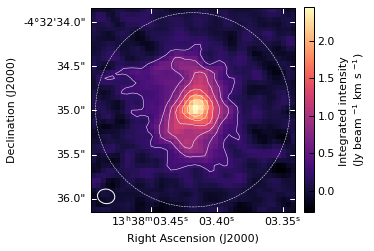

In [8]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, projection=cii_s_mom0.wcs)

# Display the moment map image
im = ax.imshow(cii_s_mom0.hdu.data, cmap='magma', vmax=np.max(cii_s_mom0.hdu.data))

lon, lat = ax.coords
lon.set_ticks(color='w',direction='in')
lat.set_ticks(color='w',direction='in')

# Add axes labels
ax.set_xlabel('Right Ascension (J2000)')
ax.set_ylabel('Declination (J2000)')

# Add a colorbar
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('Integrated intensity \n(Jy beam $^{-1}$ km s $^{-1}$)')

from matplotlib.patches import Ellipse
from matplotlib.patches import Circle
# Overplot column density contours
levels = np.array([np.sqrt(np.max(cii_mom0_acf))*i for i in range(3,50,4)])  # Define contour levels to use
print('protting',(levels/np.sqrt(np.max(cii_mom0_acf)))[levels<np.max(cii_s_mom0.hdu.data)],'$\sigma$')
ax.contour(cii_s_mom0.hdu.data, colors='w', alpha=1, linewidths=0.5, levels=levels)
ax.add_patch(Ellipse((cii_s_mom0.header['BMAJ']*1.5/cii_s_mom0.header['CDELT2']/2.,cii_s_mom0.header['BMAJ']*1.5/cii_s_mom0.header['CDELT2']/2), width=cii_s_mom0.header['BMAJ']/cii_s_mom0.header['CDELT2'], height=cii_s_mom0.header['BMIN']/cii_s_mom0.header['CDELT2'], angle=90+cii_s_mom0.header['BPA'],edgecolor='w',facecolor='none',linewidth=1))
ax.add_patch(Circle((20.5,20.5), 20, edgecolor='w',facecolor='none',linewidth=0.5, ls='--'))
plt.savefig("./fig0.pdf", bbox_inches="tight")


## 3a. measuring noise in the spatially integrated flux

In [9]:
mask=mk_aperture(cii_s_mom0, 20)
intflux_cii=mk_intflux(mask, cii_s_mom0)/cii_s_mom0.pixels_per_beam #Jy*km/s
intflux_cii_sigma=np.sqrt(mk_noise_var_noiseACF(mask, cii_mom0_acf))/cii_s_mom0.pixels_per_beam # 1sigma noise in Jy/beam
print(r"integrated flux of [CII] momment 0 map is", intflux_cii, "$\pm$", intflux_cii_sigma)

integrated flux of [CII] momment 0 map is 29.510536736029454 $\pm$ 1.0501853195407407


##  3b. measuring noise in the spatially integrated spectrum

In [10]:
# measure noise in the integrated flux for each channel.
cubemask=np.array([mask for i in range(0, cii_s.shape[0])])
specrms=mk_noisespec(mask, cii_cube_acf)#np.array([np.sqrt(mk_noise_var_noiseACF(mask, cii_cube_acf[i,:,:])) for i in range(0, cii_s[:,:,:].shape[0])])

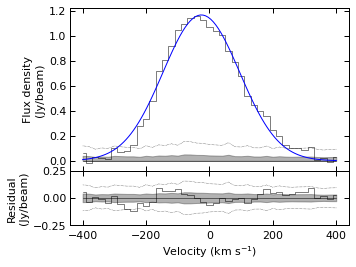

In [11]:
fig,ax=plt.subplots(2,1,figsize=(5,4),sharex=True,gridspec_kw={
                           'height_ratios': [3, 1]})
fit_g = fitting.LevMarLSQFitter()
g_init = models.Gaussian1D(amplitude=1.2, mean=0., stddev=150.,bounds={"amplitude": (0.0, 5)})
v_cii_plot=np.linspace(v_cii.value[0],v_cii.value[-1],100)
g = fit_g(g_init, v_cii.value[:], (cii_s[:,:,:]*cubemask[:,:,:]).sum(axis=1).sum(axis=1))
g = fit_g(g, v_cii.value[:], (cii_s[:,:,:]*cubemask[:,:,:]).sum(axis=1).sum(axis=1))

ax[0].plot(v_cii.value[:],(cii_s[:,:,:]*cubemask[:,:,:]).sum(axis=1).sum(axis=1),
         'k-',drawstyle='steps-mid',lw=0.5)#plot(v,flux,'k-',drawstyle='steps-mid',lw=0.5)
ax[0].plot(v_cii_plot, g(v_cii_plot),color='b')
ax[0].fill_between(v_cii.value,v_cii.value*0,v_cii.value*0+specrms,color='k',alpha=0.3)
ax[0].plot(v_cii.value,v_cii.value*0+specrms*3,'k:',lw=0.5)
ax[0].plot((v_cii.value),v_cii*0,'k',lw=0.5)
#ax[0].plot(vreg1.value, vreg1.value*0-0.3, color='k')

ax[1].plot(v_cii.value[:],(cii_s[:,:,:]*cubemask[:,:,:]).sum(axis=1).sum(axis=1)-g(v_cii.value[:]),'k-',drawstyle='steps-mid',lw=0.5)
ax[1].plot(v_cii.value,v_cii.value*0.+specrms*3,'k:',lw=0.5)
ax[1].plot(v_cii.value,v_cii.value*0.-specrms*3,'k:',lw=0.5)
ax[1].fill_between(v_cii.value,v_cii.value*0.+specrms*(-1),v_cii.value*0.+specrms,color='k',alpha=0.3)
ax[1].plot((v_cii.value),v_cii.value*0,'k',lw=0.5)
#ax[1].fill_between(v_cii,v_cii.value*0+specrms*(-1),v_cii.value*0+specrms,color='k',alpha=0.3)
ax[1].set_ylim(-0.25,0.25)
plt.xlabel('Velocity (km s$^{-1}$)')
ax[0].set_ylabel('Flux density\n(Jy/beam)')
ax[1].set_ylabel('Residual\n(Jy/beam)')
plt.subplots_adjust(hspace=0.)


## 4. simulating noise map and noise cube. 

In [12]:
%load_ext autoreload
%autoreload 2

In [13]:
snoise_band7=mk_simnoise(50, band7_acf)
snoise_cii_mom0=mk_simnoise(50, cii_mom0_acf)
snoise_cube=mk_simnoise_cube(50, cii_cube_acf)

It took 1.6622769832611084 second to generate 50x50 noise map


/home01/tsukuitk/anaconda3/envs/py37_jam/lib/python3.7/site-packages/scipy/stats/_multivariate.py:653: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


It took 1.6982331275939941 second to generate 50x50 noise map
It took 68.03824591636658 second to generate 41x50x50 (v, x, y) noise cube


peak do not coicide with the image center


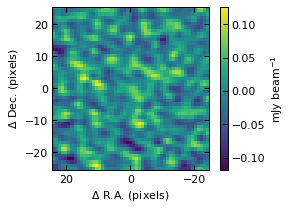

In [14]:
# Actual noise map 
Width=200
plt.imshow(zoomcen(band7_noise,Width)[100:151,150:201]*1000,extent=[25-0.5,-25+.5,-25-0.5,25+.5])
plt.xlabel(r"$\Delta$ R.A. (pixels)")
plt.ylabel(r"$\Delta$ Dec. (pixels)")
plt.colorbar(label="mJy beam$^{-1}$")
plt.savefig("./fig10a.pdf", bbox_inches="tight")

peak do not coicide with the image center
peak do not coicide with the image center


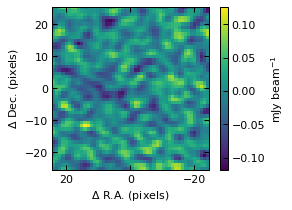

In [15]:
# Simulated noise map 
plt.imshow(snoise_band7*1000, extent=[25-0.5,-25+.5,-25-0.5,25+.5],
           vmin=(zoomcen(band7_noise,Width)[100:151,150:201]*1000).min()
           ,vmax=(zoomcen(band7_noise,Width)[100:151,150:201]*1000).max())
plt.xlabel(r"$\Delta$ R.A. (pixels)")
plt.ylabel(r"$\Delta$ Dec. (pixels)")
plt.colorbar(label="mJy beam$^{-1}$")
plt.savefig("./fig10b.pdf", bbox_inches="tight")

peak do not coicide with the image center
peak do not coicide with the image center


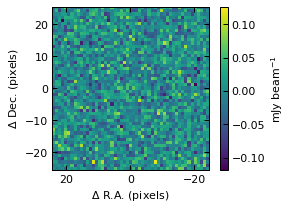

In [16]:
# Uncorrelated noise map
plt.imshow(np.random.normal(0, band7_acf.max()**0.5, 51*51).reshape(51,51)*1000,extent=[25-0.5,-25+.5,-25-0.5,25+.5],
           vmin=(zoomcen(band7_noise,Width)[100:151,150:201]*1000).min()
           ,vmax=(zoomcen(band7_noise,Width)[100:151,150:201]*1000).max())
plt.xlabel(r"$\Delta$ R.A. (pixels)")
plt.ylabel(r"$\Delta$ Dec. (pixels)")
plt.colorbar(label="mJy beam$^{-1}$")
plt.savefig("./fig10c.pdf", bbox_inches="tight")